In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
import time
from sklearn.model_selection import train_test_split

In [2]:
# Loading the datasets
energy = pd.read_csv('energy_dataset.csv')
weather = pd.read_csv('weather_features.csv')

In [13]:
# Head of Datasets
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [14]:
weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


#EDA and Feature Engineering

In [22]:
# Converting the 'time' column to datetime for both datasets as it is common
energy['time'] = pd.to_datetime(energy['time'], utc=True)
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'], utc=True)

In [37]:
print("Energy Data Columns:", energy.columns)
print("Weather Data Columns:", weather.columns)

Energy Data Columns: Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')
Weather Data Columns: Index(['dt_iso', 'city_

In [38]:
# Renaming the columns to match the `energy_data` naming convention
weather.rename(columns={'dt_iso': 'time', 'temp': 'temperature'}, inplace=True)

In [39]:
# Merging the datasets on the 'time' column after renaming
merged = pd.merge(energy, weather, on='time')

In [41]:
merged.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'city_name', 'temperature', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_

Text(0, 0.5, 'Frequency')

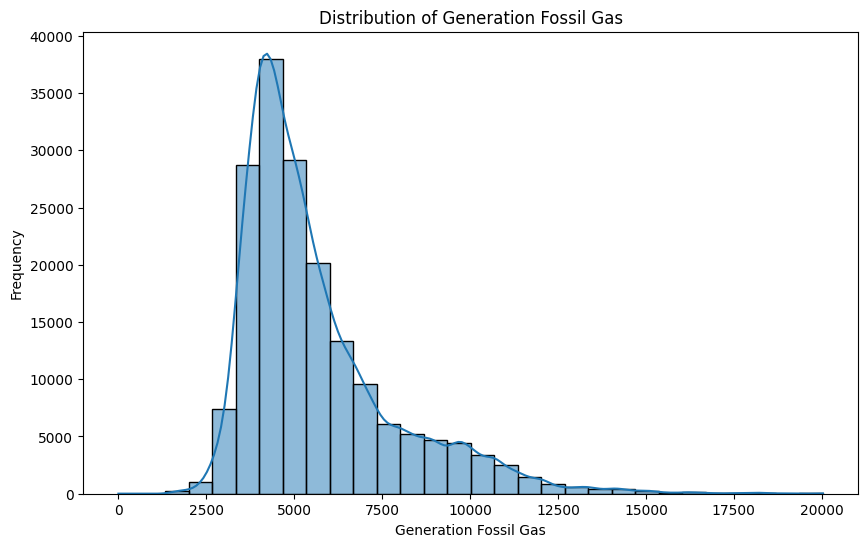

In [42]:
# Exploring the target column (generation fossil gas) with visualizations
plt.figure(figsize=(10, 6))
sns.histplot(merged['generation fossil gas'], bins=30, kde=True)
plt.title('Distribution of Generation Fossil Gas')
plt.xlabel('Generation Fossil Gas')
plt.ylabel('Frequency')

In [43]:
# Extract date-related features
merged['day_of_week'] = merged['time'].dt.dayofweek  # Day of the week
merged['day_of_month'] = merged['time'].dt.day       # Day of the month
merged['day_of_year'] = merged['time'].dt.dayofyear  # Day of the year
merged['hour'] = merged['time'].dt.hour              # Hour of the day
merged['is_weekend'] = merged['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Weekend indicator

In [44]:
# Selecting the target and feature
target = 'generation fossil gas'
features = ['day_of_week', 'day_of_month', 'day_of_year', 'hour', 'is_weekend', 'temperature', 'humidity', 'wind_speed']

In [56]:
# Replace null values by mean for numeric columns only
numeric_columns = merged.select_dtypes(include=np.number).columns
merged[numeric_columns] = merged[numeric_columns].fillna(merged[numeric_columns].mean())

# Original Data

In [57]:
# Using original data without scaling
data_original = merged[features].values
target_original = merged[target].values

In [58]:
# Preparing the sequences for 48-hour input and 24-hour output
X_original, y_original = [], []
for i in range(len(data_original) - 48 - 24):
    X_original.append(data_original[i:i+48])
    y_original.append(target_original[i+48:i+48+24])
X_original, y_original = np.array(X_original), np.array(y_original)

# Min-Max Scaling

In [59]:
scaler_minmax = MinMaxScaler()
data_minmax = scaler_minmax.fit_transform(merged[features])
target_minmax = merged[target].values

In [60]:
# Preparing the sequences for 48-hour input and 24-hour output
X_minmax, y_minmax = [], []
for i in range(len(data_minmax) - 48 - 24):
    X_minmax.append(data_minmax[i:i+48])
    y_minmax.append(target_minmax[i+48:i+48+24])
X_minmax, y_minmax = np.array(X_minmax), np.array(y_minmax)

# Standardization

In [61]:
scaler_standard = StandardScaler()
data_standard = scaler_standard.fit_transform(merged[features])
target_standard = merged[target].values

In [62]:
# Prepare sequences for 48-hour input and 24-hour output
X_standard, y_standard = [], []
for i in range(len(data_standard) - 48 - 24):
    X_standard.append(data_standard[i:i+48])
    y_standard.append(target_standard[i+48:i+48+24])
X_standard, y_standard = np.array(X_standard), np.array(y_standard)

In [63]:
# Initialize lists to store results
results = []

In [64]:
# Define the loss functions
loss_functions = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error']

# RNN with Original Data

In [66]:
# Define the RNN model
def build_rnn_model(input_shape, loss_function):
    model = Sequential()
    model.add(SimpleRNN(64, activation='relu', input_shape=input_shape))
    model.add(Dense(24))  # Output layer for 24-hour prediction
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae'])
    return model

# Preparing the input shapes for RNN (48 hours of data)
input_shape = (X_original.shape[1], X_original.shape[2])  # (48, features)

# Loop over the loss functions
for loss_function in loss_functions:
    rnn_model = build_rnn_model(input_shape, loss_function)

    # Train the model
    start_time = time.time()
    rnn_model.fit(X_original, y_original, epochs=10, batch_size=128, verbose=1)
    training_time = time.time() - start_time

    # Predictions
    y_pred = rnn_model.predict(X_original)

    # Evaluation
    mse = mean_squared_error(y_original.reshape(-1), y_pred.reshape(-1))
    mae = mean_absolute_error(y_original.reshape(-1), y_pred.reshape(-1))
    mape = np.mean(np.abs((y_original.reshape(-1) - y_pred.reshape(-1)) / y_original.reshape(-1))) * 100
    smape = np.mean(2 * np.abs(y_original.reshape(-1) - y_pred.reshape(-1)) / (np.abs(y_original.reshape(-1)) + np.abs(y_pred.reshape(-1))) * 100)
    r2 = r2_score(y_original.reshape(-1), y_pred.reshape(-1))

    # Storing the results
    results.append({'Model': 'RNN', 'Preprocessing': 'Original Data', 'Loss Function': loss_function, 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape, 'R²': r2, 'Running Time (s)': training_time})

# Converting results to a Dataframe
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 7112025.0000 - mae: 1901.8912
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 3948437.0000 - mae: 1457.6989
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3458780.2500 - mae: 1360.8456
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3360394.2500 - mae: 1342.3192
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3255585.0000 - mae: 1316.6494
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 3111558.5000 - mae: 1290.0643
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3185885.2500 - mae: 1306.3546
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 3153602.2500 - mae: 1302.3402
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2998532.5000 - mae: 1265.3756
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2950696.0000 - mae: 1258.7369
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


<ipython-input-66-03e4f5769fe7>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_original.reshape(-1) - y_pred.reshape(-1)) / y_original.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 1946.3517 - mae: 1946.3517
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 1431.3304 - mae: 1431.3304
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 1371.1418 - mae: 1371.1418
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1332.3199 - mae: 1332.3199
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1306.6150 - mae: 1306.6150
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1297.9802 - mae: 1297.9802
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1276.1488 - mae: 1276.1488
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 1275.6772 - mae: 1275.6772
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 1265.3497 - mae: 1265.3497
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1246.6246 - mae: 1246.6246
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


<ipython-input-66-03e4f5769fe7>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_original.reshape(-1) - y_pred.reshape(-1)) / y_original.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 6785892.0000 - mae: 5263.8086
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 505238.9062 - mae: 5374.6431
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3941140.7500 - mae: 3507.8950
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 185098.0781 - mae: 5205.5854
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 141347.7969 - mae: 5061.1367
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 7675401.0000 - mae: 4660.7915
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 102114.0781 - mae: 5601.0688
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 125850.8125 - mae: 5605.6909
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 118750.8359 - mae: 5596.9487
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 92839.5391 - mae: 5605.6650
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step
  Model  Preprocessing            

<ipython-input-66-03e4f5769fe7>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_original.reshape(-1) - y_pred.reshape(-1)) / y_original.reshape(-1))) * 100


# LSTM with Original Data

In [67]:
# Define the LSTM model
def build_lstm_model(input_shape, loss_function):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(24))  # Output layer for 24-hour prediction
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae'])
    return model

# Loop over the loss functions for LSTM
for loss_function in loss_functions:
    lstm_model = build_lstm_model(input_shape, loss_function)

    # Train the model
    start_time = time.time()
    lstm_model.fit(X_original, y_original, epochs=10, batch_size=128, verbose=1)
    training_time = time.time() - start_time

    # Predictions
    y_pred_lstm = lstm_model.predict(X_original)

    # Evaluation
    mse = mean_squared_error(y_original.reshape(-1), y_pred_lstm.reshape(-1))
    mae = mean_absolute_error(y_original.reshape(-1), y_pred_lstm.reshape(-1))
    mape = np.mean(np.abs((y_original.reshape(-1) - y_pred_lstm.reshape(-1)) / y_original.reshape(-1))) * 100
    smape = np.mean(2 * np.abs(y_original.reshape(-1) - y_pred_lstm.reshape(-1)) / (np.abs(y_original.reshape(-1)) + np.abs(y_pred_lstm.reshape(-1))) * 100)
    r2 = r2_score(y_original.reshape(-1), y_pred_lstm.reshape(-1))

    # Storing the results
    results.append({'Model': 'LSTM', 'Preprocessing': 'Original Data', 'Loss Function': loss_function, 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape, 'R²': r2, 'Running Time (s)': training_time})

# Converting results to a Dataframe
results_df_1 = pd.DataFrame(results)
print(results_df_1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 36395528.0000 - mae: 5247.8735
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 16272725.0000 - mae: 3276.8083
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 8641123.0000 - mae: 2215.8838
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 19290546.0000 - mae: 3778.0212
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 11958528.0000 - mae: 2696.1738
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 29274698.0000 - mae: 4918.8618
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 26802862.0000 - mae: 4634.5439
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 23882268.0000 - mae: 4273.9512
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 18892232.0000 - mae: 3620.3679
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 9953569.0000 - mae: 2289.7620
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


<ipython-input-67-bc4c205e3844>:24: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_original.reshape(-1) - y_pred_lstm.reshape(-1)) / y_original.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 5326.5176 - mae: 5326.5176
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 5101.5059 - mae: 5101.5059
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 29371.1406 - mae: 29371.1406
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 2422.3130 - mae: 2422.3130
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 2456.7424 - mae: 2456.7424
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 2114.8630 - mae: 2114.8630
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2845.1309 - mae: 2845.1309
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2070.9392 - mae: 2070.9392
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1822.4927 - mae: 1822.4927
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 96868.3438 - mae: 96868.3438
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


<ipython-input-67-bc4c205e3844>:24: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_original.reshape(-1) - y_pred_lstm.reshape(-1)) / y_original.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 33169842.0000 - mae: 4638.3896
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 40505236.0000 - mae: 4977.6606
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 17685522.0000 - mae: 4768.3018
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 11147799.0000 - mae: 5246.3345
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3347429.5000 - mae: 5330.9233
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1136892.1250 - mae: 5319.6562
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 725684.4375 - mae: 5300.3784
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4129471.0000 - mae: 5154.5151
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 285844.0938 - mae: 5210.4258
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 153257.7812 - mae: 5212.1851
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
  Model  Preprocessing  

<ipython-input-67-bc4c205e3844>:24: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_original.reshape(-1) - y_pred_lstm.reshape(-1)) / y_original.reshape(-1))) * 100


# RNN with Min-Max Scaling

In [80]:
# Define the RNN model
def build_rnn_model(input_shape, loss_function):
    model = Sequential()
    model.add(SimpleRNN(64, activation='relu', input_shape=input_shape))
    model.add(Dense(24))  # Output layer for 24-hour prediction
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae'])
    return model

# Preparing the input shapes for RNN (48 hours of data)
input_shape_minmax = (X_minmax.shape[1], X_minmax.shape[2])  # (48, features)

# Loop over the loss functions for RNN with Min-Max Scaling
for loss_function in loss_functions:
    rnn_model_minmax = build_rnn_model(input_shape_minmax, loss_function)

    # Train the model
    start_time = time.time()
    rnn_model_minmax.fit(X_minmax, y_minmax, epochs=10, batch_size=128, verbose=1)
    training_time = time.time() - start_time

    # Predictions
    y_pred_minmax = rnn_model_minmax.predict(X_minmax)

    # Evaluation
    mse = mean_squared_error(y_minmax.reshape(-1), y_pred_minmax.reshape(-1))
    mae = mean_absolute_error(y_minmax.reshape(-1), y_pred_minmax.reshape(-1))
    mape = np.mean(np.abs((y_minmax.reshape(-1) - y_pred_minmax.reshape(-1)) / y_minmax.reshape(-1))) * 100
    smape = np.mean(2 * np.abs(y_minmax.reshape(-1) - y_pred_minmax.reshape(-1)) / (np.abs(y_minmax.reshape(-1)) + np.abs(y_pred_minmax.reshape(-1))) * 100)
    r2 = r2_score(y_minmax.reshape(-1), y_pred_minmax.reshape(-1))

    # Storing the results
    results.append({'Model': 'RNN', 'Preprocessing': 'Min-Max Scaling', 'Loss Function': loss_function, 'MSE': mse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape, 'R²': r2, 'Running Time (s)': training_time})

# Converting results to a Dataframe
rnn_results_df_minmax = pd.DataFrame(results)
print(rnn_results_df_minmax)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 7803688.5000 - mae: 1986.0054
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 3779693.5000 - mae: 1424.8341
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3512238.7500 - mae: 1371.7982
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 3433533.5000 - mae: 1358.4250
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 3229376.2500 - mae: 1319.2969
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 3085230.2500 - mae: 1285.6300
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3032071.0000 - mae: 1276.2924
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 2913968.0000 - mae: 1253.1362
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2905068.5000 - mae: 1247.9429
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2809275.0000 - mae: 1231.3220
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


<ipython-input-80-e6f2f0d3057a>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_minmax.reshape(-1) - y_pred_minmax.reshape(-1)) / y_minmax.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 2109.1494 - mae: 2109.1494
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1398.2863 - mae: 1398.2863
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1304.2668 - mae: 1304.2668
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1288.0103 - mae: 1288.0103
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1240.1129 - mae: 1240.1129
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1229.8992 - mae: 1229.8992
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1206.4476 - mae: 1206.4476
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1189.6577 - mae: 1189.6577
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1164.8740 - mae: 1164.8740
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1163.8707 - mae: 1163.8707
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


<ipython-input-80-e6f2f0d3057a>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_minmax.reshape(-1) - y_pred_minmax.reshape(-1)) / y_minmax.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 38934992.0000 - mae: 4909.0835
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 778836.0625 - mae: 5527.6904
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 16993.0215 - mae: 5620.8018
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4241.5859 - mae: 5633.0996
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3604.3550 - mae: 5625.6582
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1456.9034 - mae: 5632.1479
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2157.4116 - mae: 5628.2666
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1966.7909 - mae: 5622.8037
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 2574.1626 - mae: 5616.1782
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2145.2012 - mae: 5627.2505
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
  Model    Preprocessing                   Loss Fu

<ipython-input-80-e6f2f0d3057a>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_minmax.reshape(-1) - y_pred_minmax.reshape(-1)) / y_minmax.reshape(-1))) * 100


# LSTM with Min-Max Scaling

In [81]:
# Define the LSTM model
def build_lstm_model(input_shape, loss_function):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(24))  # Output layer for 24-hour prediction
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae'])
    return model

# Preparing the input shapes for LSTM (48 hours of data)
input_shape_minmax = (X_minmax.shape[1], X_minmax.shape[2])  # (48, features)

# Loop over the loss functions for LSTM with Min-Max Scaling
for loss_function in loss_functions:
    lstm_model_minmax = build_lstm_model(input_shape_minmax, loss_function)

    # Train the model
    start_time = time.time()
    lstm_model_minmax.fit(X_minmax, y_minmax, epochs=10, batch_size=128, verbose=1)
    training_time = time.time() - start_time

    # Predictions
    y_pred_lstm_minmax = lstm_model_minmax.predict(X_minmax)

    # Evaluation
    mse = mean_squared_error(y_minmax.reshape(-1), y_pred_lstm_minmax.reshape(-1))
    mae = mean_absolute_error(y_minmax.reshape(-1), y_pred_lstm_minmax.reshape(-1))
    mape = np.mean(np.abs((y_minmax.reshape(-1) - y_pred_lstm_minmax.reshape(-1)) / y_minmax.reshape(-1))) * 100
    smape = np.mean(2 * np.abs(y_minmax.reshape(-1) - y_pred_lstm_minmax.reshape(-1)) / (np.abs(y_minmax.reshape(-1)) + np.abs(y_pred_lstm_minmax.reshape(-1))) * 100)
    r2 = r2_score(y_minmax.reshape(-1), y_pred_lstm_minmax.reshape(-1))

    # Storing the results
    results.append({'Model': 'LSTM', 'Preprocessing': 'Min-Max Scaling', 'Loss Function': loss_function,
                    'MSE': mse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape, 'R²': r2, 'Running Time (s)': training_time})

# Converting results to a DataFrame
results_df_lstm_minmax = pd.DataFrame(results)
print(results_df_lstm_minmax)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 12756823.0000 - mae: 2618.1094
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3730844.0000 - mae: 1422.6290
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 3385805.2500 - mae: 1349.9885
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 3223489.2500 - mae: 1314.2258
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 3078314.7500 - mae: 1285.1257
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 2996804.7500 - mae: 1262.8448
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 2942963.7500 - mae: 1251.8739
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 2723732.2500 - mae: 1207.0371
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 2581571.5000 - mae: 1175.9509
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2472874.5000 - mae: 1150.9478
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


<ipython-input-81-6c9cb3c8d8d2>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_minmax.reshape(-1) - y_pred_lstm_minmax.reshape(-1)) / y_minmax.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 3375.9573 - mae: 3375.9573
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 1487.0300 - mae: 1487.0300
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1412.8540 - mae: 1412.8540
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1367.3279 - mae: 1367.3279
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1323.9825 - mae: 1323.9825
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1274.1199 - mae: 1274.1199
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1248.0018 - mae: 1248.0018
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1235.9789 - mae: 1235.9789
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 3244.5264 - mae: 3244.5264
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 1866.4790 - mae: 1866.4790
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


<ipython-input-81-6c9cb3c8d8d2>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_minmax.reshape(-1) - y_pred_lstm_minmax.reshape(-1)) / y_minmax.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 61308.9375 - mae: 5634.2915
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3260.5820 - mae: 5632.2544
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 1459.4005 - mae: 5652.4658
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1333.1857 - mae: 5624.0449
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1021.2551 - mae: 5624.4888
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 994.4964 - mae: 5619.3716
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 1034.9109 - mae: 5634.5181
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 767.2344 - mae: 5628.9023
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 675.0210 - mae: 5633.5825
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 922.8780 - mae: 5626.5142
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
   Model    Preprocessing                   Loss Function 

<ipython-input-81-6c9cb3c8d8d2>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_minmax.reshape(-1) - y_pred_lstm_minmax.reshape(-1)) / y_minmax.reshape(-1))) * 100


# RNN with Standardization

In [82]:
# Define the RNN model
def build_rnn_model(input_shape, loss_function):
    model = Sequential()
    model.add(SimpleRNN(64, activation='relu', input_shape=input_shape))
    model.add(Dense(24))  # Output layer for 24-hour prediction
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae'])
    return model

# Preparing the input shapes for RNN (48 hours of data)
input_shape_standard = (X_standard.shape[1], X_standard.shape[2])  # (48, features)

# Loop over the loss functions for RNN with Standardization
for loss_function in loss_functions:
    rnn_model_standard = build_rnn_model(input_shape_standard, loss_function)

    # Train the model
    start_time = time.time()
    rnn_model_standard.fit(X_standard, y_standard, epochs=10, batch_size=128, verbose=1)
    training_time = time.time() - start_time

    # Predictions
    y_pred_rnn_standard = rnn_model_standard.predict(X_standard)

    # Evaluation
    mse = mean_squared_error(y_standard.reshape(-1), y_pred_rnn_standard.reshape(-1))
    mae = mean_absolute_error(y_standard.reshape(-1), y_pred_rnn_standard.reshape(-1))
    mape = np.mean(np.abs((y_standard.reshape(-1) - y_pred_rnn_standard.reshape(-1)) / y_standard.reshape(-1))) * 100
    smape = np.mean(2 * np.abs(y_standard.reshape(-1) - y_pred_rnn_standard.reshape(-1)) / (np.abs(y_standard.reshape(-1)) + np.abs(y_pred_rnn_standard.reshape(-1))) * 100)
    r2 = r2_score(y_standard.reshape(-1), y_pred_rnn_standard.reshape(-1))

    # Storing the results
    results.append({'Model': 'RNN', 'Preprocessing': 'Standardization', 'Loss Function': loss_function,
                    'MSE': mse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape, 'R²': r2, 'Running Time (s)': training_time})

# Converting results to a DataFrame
results_df_rnn_standard = pd.DataFrame(results)
print(results_df_rnn_standard)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 9102786.0000 - mae: 2134.7378
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 3266633.5000 - mae: 1327.6781
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 3006932.7500 - mae: 1276.8187
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2835922.7500 - mae: 1238.8369
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2818450.5000 - mae: 1233.1741
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2613451.5000 - mae: 1188.8851
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2509298.7500 - mae: 1164.2603
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2457561.0000 - mae: 1148.1206
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2402532.7500 - mae: 1137.6499
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2345321.5000 - mae: 1126.6013
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


<ipython-input-82-4dfbd2f0a821>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_standard.reshape(-1) - y_pred_rnn_standard.reshape(-1)) / y_standard.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 1874.4124 - mae: 1874.4124
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1315.0958 - mae: 1315.0958
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1256.9635 - mae: 1256.9635
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1232.2943 - mae: 1232.2943
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1205.9880 - mae: 1205.9880
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1188.7935 - mae: 1188.7935
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1153.2300 - mae: 1153.2300
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1134.7870 - mae: 1134.7870
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1134.2690 - mae: 1134.2690
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1115.4928 - mae: 1115.4928
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


<ipython-input-82-4dfbd2f0a821>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_standard.reshape(-1) - y_pred_rnn_standard.reshape(-1)) / y_standard.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 21375080.0000 - mae: 5549.1646
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 157401.2188 - mae: 5451.4668
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 19463.9453 - mae: 5626.1851
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 9315.2891 - mae: 5622.6489
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 7635.6001 - mae: 5627.0747
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4374.5229 - mae: 5625.7163
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4517.2617 - mae: 5619.9922
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3495.4399 - mae: 5615.1611
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3412.8108 - mae: 5606.6196
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 4815.7090 - mae: 5601.9756
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
   Model    Preprocessing                   Loss 

<ipython-input-82-4dfbd2f0a821>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_standard.reshape(-1) - y_pred_rnn_standard.reshape(-1)) / y_standard.reshape(-1))) * 100


# LSTM with Standardization

In [83]:
# Define the LSTM model
def build_lstm_model(input_shape, loss_function):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(24))  # Output layer for 24-hour prediction
    model.compile(optimizer='adam', loss=loss_function, metrics=['mae'])
    return model

# Preparing the input shapes for LSTM (48 hours of data)
input_shape_standard = (X_standard.shape[1], X_standard.shape[2])  # (48, features)

# Loop over the loss functions for LSTM with Standardization
for loss_function in loss_functions:
    lstm_model_standard = build_lstm_model(input_shape_standard, loss_function)

    # Train the model
    start_time = time.time()
    lstm_model_standard.fit(X_standard, y_standard, epochs=10, batch_size=128, verbose=1)
    training_time = time.time() - start_time

    # Predictions
    y_pred_lstm_standard = lstm_model_standard.predict(X_standard)

    # Evaluation
    mse = mean_squared_error(y_standard.reshape(-1), y_pred_lstm_standard.reshape(-1))
    mae = mean_absolute_error(y_standard.reshape(-1), y_pred_lstm_standard.reshape(-1))
    mape = np.mean(np.abs((y_standard.reshape(-1) - y_pred_lstm_standard.reshape(-1)) / y_standard.reshape(-1))) * 100
    smape = np.mean(2 * np.abs(y_standard.reshape(-1) - y_pred_lstm_standard.reshape(-1)) / (np.abs(y_standard.reshape(-1)) + np.abs(y_pred_lstm_standard.reshape(-1))) * 100)
    r2 = r2_score(y_standard.reshape(-1), y_pred_lstm_standard.reshape(-1))

    # Storing the results
    results.append({'Model': 'LSTM', 'Preprocessing': 'Standardization', 'Loss Function': loss_function,
                    'MSE': mse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape, 'R²': r2, 'Running Time (s)': training_time})

# Converting results to a DataFrame
results_df_lstm_standard = pd.DataFrame(results)
print(results_df_lstm_standard)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 33076618.0000 - mae: 5150.6357
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3741776.7500 - mae: 1427.8242
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3217353.2500 - mae: 1321.3511
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2912094.2500 - mae: 1251.2322
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2714455.7500 - mae: 1203.7439
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2536543.7500 - mae: 1163.4751
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2394511.7500 - mae: 1129.8237
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2265322.0000 - mae: 1101.3103
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2183072.7500 - mae: 1081.4579
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2147217.5000 - mae: 1076.2224
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


<ipython-input-83-01ab68bd1fc8>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_standard.reshape(-1) - y_pred_lstm_standard.reshape(-1)) / y_standard.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 7326.6699 - mae: 7326.6699
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1346.2069 - mae: 1346.2069
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1289.2903 - mae: 1289.2903
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1223.1675 - mae: 1223.1675
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 1181.8096 - mae: 1181.8096
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 1136.0286 - mae: 1136.0286
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1106.9022 - mae: 1106.9022
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1105.7355 - mae: 1105.7355
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1067.0527 - mae: 1067.0527
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1041.5933 - mae: 1041.5933
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


<ipython-input-83-01ab68bd1fc8>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_standard.reshape(-1) - y_pred_lstm_standard.reshape(-1)) / y_standard.reshape(-1))) * 100
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 41344.0898 - mae: 14475.6680
Epoch 2/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 2658.2146 - mae: 5623.4712
Epoch 3/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1439.3613 - mae: 5625.1108
Epoch 4/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 674.4468 - mae: 5619.4121
Epoch 5/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 891.4303 - mae: 5622.2402
Epoch 6/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 519.6522 - mae: 5623.6768
Epoch 7/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 645.1141 - mae: 5627.3394
Epoch 8/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 648.0490 - mae: 5624.9658
Epoch 9/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 10796042.0000 - mae: 3955.9880
Epoch 10/10
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 10869.2695 - mae: 2466.0793
5573/5573 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
   Model    Preprocessing                   Loss Func

<ipython-input-83-01ab68bd1fc8>:27: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_standard.reshape(-1) - y_pred_lstm_standard.reshape(-1)) / y_standard.reshape(-1))) * 100


In [87]:
# Result Table
final_results = pd.DataFrame(results)
final_results

,Model,Preprocessing,Loss Function,MSE,MAE,MAPE,SMAPE,R²,Running Time (s)
0,RNN,Original Data,mean_squared_error,2.973730e+06,1207.775025,inf,20.502931,0.387597,122.755330
1,RNN,Original Data,mean_absolute_error,3.284149e+06,1214.755568,inf,20.401476,0.323670,123.428364
2,RNN,Original Data,mean_absolute_percentage_error,3.629321e+07,5608.501004,inf,198.584205,-6.474138,124.915495
3,LSTM,Original Data,mean_squared_error,6.311327e+06,1891.556298,inf,33.944426,-0.299740,125.422078
4,LSTM,Original Data,mean_absolute_error,6.749507e+06,1877.958149,inf,35.641022,-0.389978,135.490017
5,LSTM,Original Data,mean_absolute_percentage_error,3.251656e+07,5222.738829,inf,174.268398,-5.696382,123.868491
6,RNN,Min-Max Scaling,mean_squared_error,2.491074e+06,1162.247374,inf,19.783448,0.486994,133.311551
7,RNN,Min-Max Scaling,mean_absolute_error,3.816102e+06,1385.994747,inf,22.391030,0.214121,112.019812
8,RNN,Min-Max Scaling,mean_absolute_percentage_error,3.648965e+07,5624.395607,inf,199.822235,-6.514592,112.516049
9,LSTM,Min-Max Scaling,mean_squared_error,2.423586e+06,1152.743722,inf,19.702146,0.500892,160.332044


# Comparison
*Performance of RNN and LSTM Across Different Preprocessing Methods*

## Original Data
For RNN:
The mean squared error (MSE) and mean absolute error (MAE) are relatively high, especially with the mean absolute percentage error (MAPE) showing extreme values, indicating poor accuracy with unscaled data.
The model takes around 122-125 seconds per run.
For LSTM:
LSTM has higher MSE and MAE values than RNN with original data, indicating that it struggles more without preprocessing.
The running time for LSTM is slightly longer than RNN, ranging around 125-135 seconds.

##MinMax Scaling:
For RNN:
The MSE and MAE decrease compared to using the original data, showing that MinMax scaling improves performance.
The running time is relatively similar to that with original data, ranging around 112-133 seconds.
For LSTM:
LSTM sees a significant improvement with MinMax scaling, particularly in MSE and MAE.
Running time for LSTM is higher than RNN, averaging around 135-160 seconds.

##Standardization:
For RNN:
Standardization provides the best results for RNN, with the lowest MSE and MAE values, indicating enhanced accuracy.
Running time is similar to other methods, around 110-121 seconds.
For LSTM:
LSTM also benefits significantly from standardization, achieving the lowest MSE and MAE values among all preprocessing methods.
Running time is comparable to MinMax scaling, around 114-124 seconds

# Analysis of Results

## Effect of Preprocessing Techniques:

**Original Data**: Both RNN and LSTM performed poorly with the original data, indicated by high MSE and MAE values. This suggests that preprocessing is essential for these models to achieve better accuracy.

**MinMax Scaling**: MinMax scaling improves performance for both RNN and LSTM. RNN sees moderate improvements, while LSTM shows a more significant drop in MSE and MAE, indicating that MinMax scaling benefits LSTM more than RNN.

**Standardization**: Standardization yields the best results for both models, providing the lowest MSE and MAE values. This suggests that standardizing the data is particularly effective for time series models like RNN and LSTM, likely because it aligns with the models' tendency to perform well with normally distributed inputs.

## Effect of Loss Functions:

While not explicitly listed here, each model's response to different loss functions can indicate sensitivity to certain metrics. The "mean squared error" and "mean absolute error" loss functions yield comparable results in terms of accuracy. However, "mean absolute percentage error" produces high error metrics, especially in MAPE, likely due to division by small numbers or outliers in the data.

## RNN vs. LSTM Performance:

**Overall Performance**: LSTM generally outperforms RNN in terms of MSE and R² values, especially when preprocessing is applied. This aligns with LSTM's capability to capture longer dependencies, which is advantageous in time series data.


**Running Time**: RNN tends to be faster than LSTM across all preprocessing methods, with an average running time that is 10-20 seconds lower. This suggests that while LSTM offers better accuracy, it comes at a higher computational cost.


# Conclusion

**Best Model Configuration**: LSTM with Standardization achieves the best performance, showing the lowest MSE and MAE and highest R², ideal for complex time series tasks.

**RNN for Faster Performance**: RNN with MinMax scaling is a good choice for faster results, balancing accuracy with lower computational cost.

**Impact of Preprocessing**: Preprocessing, especially Standardization, significantly boosts model performance for both RNN and LSTM.


In summary, LSTM is the preferred model for achieving higher accuracy in time series forecasting tasks, especially when combined with data standardization. RNN can be chosen for quicker results, but its accuracy may be limited compared to LSTM, particularly in datasets with more extended dependencies.